### importing libs 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import re
import datetime
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:
%cd ../

/mnt/c/Study/CourseraFin/notebooks_and_codem01_v02


In [4]:
datapath = "data"

In [5]:
!ls {datapath}

BRK-A.csv				ind30_m_nfirms.csv
F-F_Research_Data_Factors.CSV		ind30_m_size.csv
F-F_Research_Data_Factors_daily.CSV	ind30_m_vw_rets.csv
F-F_Research_Data_Factors_m.csv		ind49_m_ew_rets.csv
Portfolios_Formed_on_ME_monthly_EW.csv	ind49_m_nfirms.csv
brka_d_ret.csv				ind49_m_size.csv
edhec-hedgefundindices.csv		ind49_m_vw_rets.csv
ind30_m_ew_rets.csv			sample_prices.csv


### Reading data EDHEC hedge fund data

In [6]:
data = pd.read_csv(datapath+'/edhec-hedgefundindices.csv',header=0,parse_dates=True,index_col=['date'])

In [7]:
data.index = data.index.to_period('M')

In [8]:
data.head()

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01,1.19,3.93,1.78,7.91,1.89,2.13,1.91,5.73,2.81,1.50,1.80,-1.66,3.17
1997-02,1.23,2.98,1.22,5.25,1.01,0.84,1.22,1.75,-0.06,0.34,1.18,4.26,1.06
1997-03,0.78,-0.21,-0.12,-1.20,0.16,-0.23,1.09,-1.19,-0.84,0.60,0.10,7.78,-0.77
1997-04,0.86,-1.70,0.30,1.19,1.19,-0.05,1.30,1.72,0.84,-0.01,1.22,-1.29,0.09
1997-05,1.56,-0.15,2.33,3.15,1.89,3.46,1.18,1.08,3.94,1.97,1.73,-7.37,2.75


In [9]:
# converting from percentages to real number
data = data/100.

In [10]:
data.head()

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01,0.0119,0.0393,0.0178,0.0791,0.0189,0.0213,0.0191,0.0573,0.0281,0.0150,0.0180,-0.0166,0.0317
1997-02,0.0123,0.0298,0.0122,0.0525,0.0101,0.0084,0.0122,0.0175,-0.0006,0.0034,0.0118,0.0426,0.0106
1997-03,0.0078,-0.0021,-0.0012,-0.0120,0.0016,-0.0023,0.0109,-0.0119,-0.0084,0.0060,0.0010,0.0778,-0.0077
1997-04,0.0086,-0.0170,0.0030,0.0119,0.0119,-0.0005,0.0130,0.0172,0.0084,-0.0001,0.0122,-0.0129,0.0009
1997-05,0.0156,-0.0015,0.0233,0.0315,0.0189,0.0346,0.0118,0.0108,0.0394,0.0197,0.0173,-0.0737,0.0275


In [11]:
def skewness(ser):
    s = ser.std(ddof=0)
    m = ser.mean()
    return ((ser-m)**3).mean()/s**3

In [12]:
def kurtosis(ser):
    s = ser.std(ddof=0)
    m = ser.mean()
    return ((ser-m)**4).mean()/s**4

In [13]:
def calculate_gauss_var(ser,qvar=0.01,modified=False):
    if isinstance(ser,pd.DataFrame):
        return ser.aggregate(calculate_gauss_var,modified=modified)
    elif isinstance(ser,pd.Series):
        z = norm.ppf(qvar)
        if not modified:
            return -(ser.mean()+z*ser.std(ddof=0))
        else:
            s,k = skewness(ser),kurtosis(ser)
            z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36)
            return -(ser.mean()+z*ser.std(ddof=0))
            

In [14]:
calculate_gauss_var(data["2000":])

Convertible Arbitrage     0.034845
CTA Global                0.050336
Distressed Securities     0.031430
Emerging Markets          0.058070
Equity Market Neutral     0.014772
Event Driven              0.030853
Fixed Income Arbitrage    0.019519
Global Macro              0.024619
Long/Short Equity         0.039420
Merger Arbitrage          0.015355
Relative Value            0.021605
Short Selling             0.102130
Funds Of Funds            0.029385
dtype: float64

In [15]:
calculate_gauss_var(data["2000":],modified=True)

Convertible Arbitrage     0.103666
CTA Global                0.046643
Distressed Securities     0.049669
Emerging Markets          0.086796
Equity Market Neutral     0.041432
Event Driven              0.045732
Fixed Income Arbitrage    0.066479
Global Macro              0.022786
Long/Short Equity         0.051381
Merger Arbitrage          0.021282
Relative Value            0.048985
Short Selling             0.098323
Funds Of Funds            0.048793
dtype: float64

In [16]:
def calculate_historic_var(data,qvar=0.01):
    if isinstance(data,pd.DataFrame):
        return data.aggregate(calculate_historic_var,qvar=qvar)
    else:
        return -np.quantile(data,qvar)

In [17]:
calculate_historic_var(data["2000":])

Convertible Arbitrage     0.031674
CTA Global                0.050938
Distressed Securities     0.042642
Emerging Markets          0.065496
Equity Market Neutral     0.019800
Event Driven              0.038540
Fixed Income Arbitrage    0.030748
Global Macro              0.022632
Long/Short Equity         0.045060
Merger Arbitrage          0.022654
Relative Value            0.021788
Short Selling             0.107684
Funds Of Funds            0.027200
dtype: float64

### Industrial data 

In [18]:
!ls {datapath}

BRK-A.csv				ind30_m_nfirms.csv
F-F_Research_Data_Factors.CSV		ind30_m_size.csv
F-F_Research_Data_Factors_daily.CSV	ind30_m_vw_rets.csv
F-F_Research_Data_Factors_m.csv		ind49_m_ew_rets.csv
Portfolios_Formed_on_ME_monthly_EW.csv	ind49_m_nfirms.csv
brka_d_ret.csv				ind49_m_size.csv
edhec-hedgefundindices.csv		ind49_m_vw_rets.csv
ind30_m_ew_rets.csv			sample_prices.csv


In [19]:
import sys

In [167]:
sys.path.append('./')

In [168]:
ind_data = pd.read_csv("data/ind30_m_vw_rets.csv",index_col=0,header=0)

In [169]:
ind_data.index = pd.to_datetime(ind_data.index,format="%Y%m").to_period('M')

In [170]:
ind_data.columns = ind_data.columns.str.strip()

In [171]:
ind_data=ind_data["2013":"2017"]

In [172]:
assets = ["Books","Steel","Oil","Mines"]

In [173]:
def annualize_returns(s,periods_per_year=12):
    if isinstance(s,pd.DataFrame):
        return s.aggregate(annualize_returns)
    else:
        cp = (s/100+1).prod()
        N = s.shape[0]
        return 100*(cp**(periods_per_year/N)-1)

In [174]:
er = annualize_returns(ind_data)
cov = ind_data.cov()

In [175]:
def calc_vol(weights,cov):
    return np.sqrt((weights.T@cov)@weights)

In [176]:
def optimal_portfolio(target_ret,er,cov):
    n = cov.shape[0]
    initial_guess = np.array([1./n]*n)
    bounds=((0.,1.),)*n
    def calc_rets(w,er,target_ret):
        return np.dot(w,er)-target_ret
    met_target = {
        'type':'eq',
        'fun': calc_rets,
        'args':(er,target_ret)
    }
    weight_norm={
        'type':'eq',
        'fun': lambda x: sum(x)-1.
    }
    results = minimize(calc_vol,initial_guess,args=(cov,),bounds=bounds,constraints=[met_target,weight_norm],options={'disp':False},method='SLSQP')
    return results.x

In [177]:
def efficient_frontier(er,cov,n_points=20):
    rets = np.linspace(er.min(),er.max(),n_points)
    weights=[]
    for r in rets:
        weights.append(optimal_portfolio(r,er,cov))
    weights=np.stack(weights)
    expected_rets = weights@er
    expected_vol = np.diag(np.sqrt(weights@cov@weights.T))
    return expected_rets,expected_vol

In [178]:
r,v=efficient_frontier(er.loc[assets],cov.loc[assets,assets])

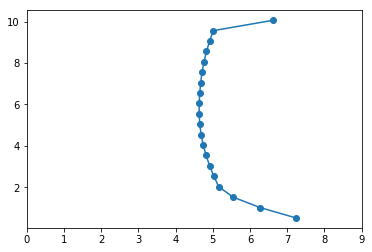

In [179]:
plt.plot(v,r,marker='o')
plt.xlim([0.,9])
plt.show()

In [180]:
def ew_portfolio(er,cov):
    n = er.shape[0]
    w = np.repeat(1./n,n)
    r,v = w@er,w.T@cov@w
    return w,r,v

In [181]:
def msr_portfolio(er,cov,rf):
    n = er.shape[0]
    initial_guess = np.repeat(1./n,n)
    bounds =((0,1),)*n
    weight_sum={
        'type':'eq',
        'fun': lambda w: np.sum(w)-1.
    }
    constraints=[weight_sum]
    def sr(w):
        r = w@er
        s = calc_vol(w,cov)
        return -(r-rf)/s
    results = minimize(sr,initial_guess,bounds=bounds,constraints=constraints,options={'disp':False},method='SLSQP')
    return results.x

In [183]:
msr_w=msr_portfolio(er[assets],cov.loc[assets,assets],rf=10)

In [184]:
msr_w

array([4.85722573e-16, 1.00000000e+00, 6.33174069e-17, 0.00000000e+00])

In [185]:
msr_r,msr_v = msr_w@er[assets],calc_vol(msr_w,cov.loc[assets,assets])

In [186]:
r,v=efficient_frontier(er.loc[assets],cov.loc[assets,assets])

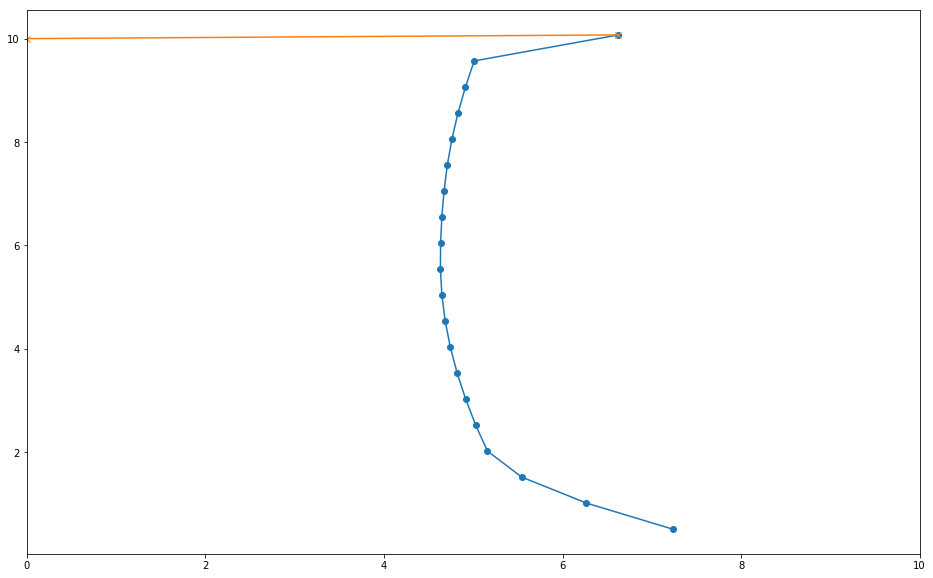

In [188]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.plot(v,r,marker='o')
ax.set_xlim([0.,10])
ax.plot([0,msr_v],[10,msr_r],marker='x')#,marker_size=20)
plt.show()

In [189]:
msr_w

array([4.85722573e-16, 1.00000000e+00, 6.33174069e-17, 0.00000000e+00])

In [190]:
assets

['Books', 'Steel', 'Oil', 'Mines']

In [75]:
def calculate_gmv(er,cov):
    n = cov.shape[0]
    initial_guess = np.repeat(1./n,n)
    bounds=((0.,1),)*n
    weights_sum={
        'type':'eq',
        'fun':lambda w: np.sum(w)-1.
    }
    results = minimize(calc_vol,initial_guess,bounds=bounds,constraints=[weights_sum],method='SLSQP',
                      options={'disp':False},args=(cov,))
    return results.x

In [206]:
calculate_gmv(er[assets],cov.loc[assets,assets])

array([0.47721023, 0.        , 0.43389054, 0.08889922])

In [204]:
wfirst=calculate_gmv(er[assets],cov.loc[assets,assets])

In [205]:
wsecond = msr_portfolio(er[assets],cov.loc[assets,assets],rf=10)

In [203]:
ind_data_2018=pd.read_csv("data/ind30_m_vw_rets.csv",index_col=0,header=0)

In [194]:
ind_data_2018.index = pd.to_datetime(ind_data_2018.index,format="%Y%m").to_period('M')

In [195]:
ind_data_2018.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.56,-5.19,1.29,2.93,10.97,-0.48,8.08,1.77,8.14,0.39,...,0.83,9.22,2.06,7.70,1.93,-23.79,0.07,1.87,0.37,5.20
1926-08,2.59,27.03,6.50,0.55,10.01,-3.58,-2.51,4.25,5.50,8.14,...,2.17,2.02,4.39,-2.38,4.88,5.39,-0.75,-0.13,4.46,6.76
1926-09,1.16,4.02,1.26,6.58,-0.99,0.73,-0.51,0.69,5.33,2.31,...,2.41,2.25,0.19,-5.54,0.05,-7.87,0.25,-0.56,-1.23,-3.86
1926-10,-3.06,-3.31,1.06,-4.76,9.47,-4.68,0.12,-0.57,-4.76,1.00,...,-0.11,-2.00,-1.09,-5.08,-2.64,-15.38,-2.20,-4.11,-5.16,-8.49
1926-11,6.35,7.29,4.55,1.66,-5.80,-0.54,1.87,5.42,5.20,3.11,...,1.63,3.77,3.64,3.84,1.60,4.67,6.52,4.33,2.24,4.00


In [196]:
ind_data_2018.columns = ind_data_2018.columns.str.strip()

In [197]:
ind_data_2018= ind_data_2018["2018"]

In [198]:
ind_data_2018

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2018-01,2.38,-0.11,0.13,17.26,4.49,-1.98,7.29,6.38,1.70,1.60,...,3.18,9.25,5.01,4.38,2.68,4.83,11.56,3.23,6.11,5.51
2018-02,-6.75,-6.76,-6.62,1.09,-3.25,-6.25,-1.95,-3.90,-5.12,-12.35,...,-7.32,-1.69,2.05,-5.28,-6.65,-5.56,-4.72,-4.19,-2.55,-4.44
2018-03,-1.87,1.27,-1.65,-0.17,0.31,2.10,0.64,-2.00,-1.86,-2.14,...,-2.52,-3.31,-2.92,-4.35,0.53,-1.04,-3.25,-0.54,-3.38,-3.40
2018-04,-1.67,-4.29,-14.16,3.31,-0.62,-5.31,3.16,-0.28,0.71,-9.54,...,-2.41,1.18,-1.95,-6.09,0.50,0.83,4.29,3.50,1.18,-1.90
2018-05,-0.78,-1.19,-1.87,9.02,-0.61,-0.24,4.21,2.43,2.42,-1.36,...,-0.93,5.86,7.84,0.79,4.86,1.69,1.36,-1.95,0.40,-0.38
2018-06,5.40,4.42,3.07,4.96,2.18,3.62,6.98,1.52,0.33,3.36,...,6.23,1.07,-1.90,-0.44,-3.65,0.23,4.36,-2.89,-0.98,-2.04
2018-07,2.21,3.50,5.24,-6.12,-4.17,2.32,0.35,6.12,4.85,-8.89,...,2.68,2.03,2.77,5.95,7.91,2.39,3.55,1.16,4.26,6.04
2018-08,-0.38,-1.86,-5.43,2.89,-4.47,2.54,5.26,4.46,0.01,3.80,...,2.95,5.24,9.93,-0.34,2.91,3.66,9.11,3.64,2.45,2.99
2018-09,-0.32,0.19,5.37,-0.09,-2.21,1.07,1.30,1.99,-2.87,-6.38,...,1.74,-0.37,-0.33,-0.30,1.05,-1.48,0.61,2.51,-1.93,1.16
2018-10,1.02,-1.57,7.90,-15.96,-6.66,-0.51,-10.14,-8.84,-12.50,-25.79,...,-0.50,-9.20,-8.06,-9.82,-9.75,-7.88,-10.21,-1.71,-5.45,-5.99


In [199]:
cov_2018 = ind_data_2018.cov()

In [207]:
vol_first = calc_vol(wfirst,cov_2018.loc[assets,assets])

In [208]:
vol_first*np.sqrt(12)

18.972011723710615

In [209]:
vol_second = calc_vol(wsecond,cov_2018.loc[assets,assets])

In [210]:
vol_second*np.sqrt(12)

21.983988181484182

In [211]:
wsecond

array([4.85722573e-16, 1.00000000e+00, 6.33174069e-17, 0.00000000e+00])